# Introdução

Neste projeto foi coletadas letras de músicas do site "vagalume.com.br" com o objetivo de predizer a categoria de uma música baseada na letra. 

As etapas realizadas são:

- Limpeza do texto
- Criação de novas variáveis e manipulações gerais
- Análises descritivas
- Avaliação das categorias de músicas
- Criação do modelo
- Avaliação dos resultados

In [1]:
## Importando bibliotecas
import pandas as pd
import os
import numpy as np

# Pré-Processamento
import re
from unidecode import unidecode 
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.corpus import stopwords 
import nltk
import string
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

# Visualização
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import fasttext


# Validação modelo
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score

# ignorando alguns erros
import warnings

In [2]:
# Lendo base
df = pd.read_pickle('../input/songs.pkl')

In [3]:
# Checando quantidade de linhas e colunas
df.shape

(11030, 8)

In [4]:
## Funções para apoio de trativas de textos e criação de variáveis

#'mim', 'pe', 'ah'

stops = ['pra', 'pro', 'vou', 'deu', 'igual']

# Limpa o texto
def transform_text(tokens):
    # html transform
    tokens = tokens.replace('<div data-plugin="googleTranslate" id="lyrics">', '').replace('</div>', '').replace('<br/>', " ")
    # stop words
    stop_words_ = STOP_WORDS.union(stopwords.words('portuguese'))
    stop_words = [unidecode(stop).lower() for stop in stop_words_] + stops
    # Split to translate
    tokens = tokens.split()
    # Concatenate
    tokens = ' '.join(tokens)
    # Remove accents
    tokens = unidecode(tokens)
    # Remove https, mentions, special characters, single character
    tokens = re.sub("(@[A-Za-z0-9]+)|(_[A-Za-z0-9]+)|(\w+:\/\/\S+)|(\W_)", " ", tokens).lower()
    # Remove pontuaction
    tokens = re.sub('['+string.punctuation+']', '', tokens)
    # Substituting multiple spaces with single space
    tokens = re.sub(r'\s+', ' ', tokens, flags=re.I)
    # Remove digits
    tokens = ''.join([i for i in tokens if not i.isdigit()])
    # Remove all single characters
    tokens = re.sub(r'\s+[a-zA-Z]\s+', ' ', tokens)
    # Split
    tokens = tokens.split()
    # Stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # Concatenate
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Retira palavras repetidas em uma sentença
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

# Unificar classes
def classes(x):
    if x == 'Gospel/Religioso':
        return 'Religioso'
    elif x == 'Funk Carioca':
        return 'Funk'
    else:
        return x

## Limpeza do Texto

In [5]:
%%time
df['Transformed'] = df['lyrics'].apply(lambda x: transform_text(x))

/home/joaoflauzino/miniconda3/lib/python3.8/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character '\ud97e' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
/home/joaoflauzino/miniconda3/lib/python3.8/site-packages/unidecode/__init__.py:50: RuntimeWarning: Surrogate character '\udc24' will be ignored. You might be using a narrow Python build.
  return _unidecode(string)
CPU times: user 23.4 s, sys: 1.98 s, total: 25.4 s
Wall time: 25.6 s


In [6]:
df['lyrics'][0]

'<div data-plugin="googleTranslate" id="lyrics">Se dirigir, não beba!<br/>Mas se for beber, me chame meu irmão<br/><br/>Saia da rotina,<br/>Então caia na folia<br/>Tem festa, festa!<br/><br/>Hoje a noite tá bombando<br/>Mulherada desfilando<br/>Eu quero festa, festa<br/><br/>Todo santo dia<br/>É a mesma agonia<br/>Vou te dizer<br/>Fazer o que?<br/><br/>O celular tá ocupado<br/>O povo estressado<br/>Sabe o que vou fazer?<br/><br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou tomar todas no bar!!<br/><br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou pro bar<br/>Já que minas não tem mar<br/>Eu vou tomar todas no bar!!<br/><br/>Saia da rotina,<br/>Então caia na folia<br/>Tem festa, festa!<br/><br/>Hoje a noite tá bombando<br/>Mulherada desfilando<br/>Eu quero festa, festa<br/><br/>Todo santo dia<br/>É a mesma agonia<br/>Vou te dizer<br/>Fazer o que?<br/><br/>O celula

In [7]:
df['Transformed'][0]

'dirigir beba beber chame irmao saia rotina caia folia festa festa hoje noite ta bombando mulherada desfilando festa festa santo dia mesma agonia celular ta ocupado estressado minas mar bar minas mar bar minas mar tomar bar minas mar bar minas mar bar minas mar tomar bar saia rotina caia folia festa festa hoje noite ta bombando mulherada desfilando festa festa santo dia mesma agonia celular ta ocupado estressado minas mar bar minas mar bar minas mar tomar bar minas mar bar minas mar bar minas mar tomar bar procurando alguem amar sentado mesa bar falando loucuras paixao rio corre mar dia encontrar esperei minas mar bar minas mar bar minas mar tomar bar minas mar bar minas mar bar minas mar tomar bar procurando alguem amar sentado mesa bar falando loucuras paixoes rio corre mar dia encontrar esperei minas mar bar minas mar bar minas mar tomar bar minas mar bar minas mar bar minas mar tomar bar'

## Manipulações gerais

In [8]:
# Considerando apenas músicas brasileiras
df_br = df[(df['is_pt'] != 'Tradução ')].copy()

## Análise descritiva

Neste caso, tem-se as categorias consideradas pelo vagalume, um dos pontos a se observar seria a possibilidade de reduzir esse número de classes. Um exemplo de redução seria:

- Funk e Funk Carioca -> Funk

In [9]:
df_br_ = df_br[df_br['category'].isin(['Axé', 'Gospel/Religioso', 'Samba', 'Pagode', 'Pop/Rock', 'MPB', 'Hip Hop', 'Heavy Metal', 'Funk', 'Funk Carioca', 'Rock Alternativo', 'Sertanejo'])]
df_br_['category'] = df_br_['category'].apply(lambda x: classes(x))
df_br_['category'].unique()

<ipython-input-9-1cd401898d4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_br_['category'] = df_br_['category'].apply(lambda x: classes(x))


array(['Axé', 'Funk', 'Religioso', 'Heavy Metal', 'Hip Hop', 'MPB',
       'Pagode', 'Pop/Rock', 'Rock Alternativo', 'Samba', 'Sertanejo'],
      dtype=object)

In [10]:
# Filtrando classes que tenha pelo menos 100 registros
# df_br_ = df_br_.groupby('category').filter(lambda x: len(x) >= 100)

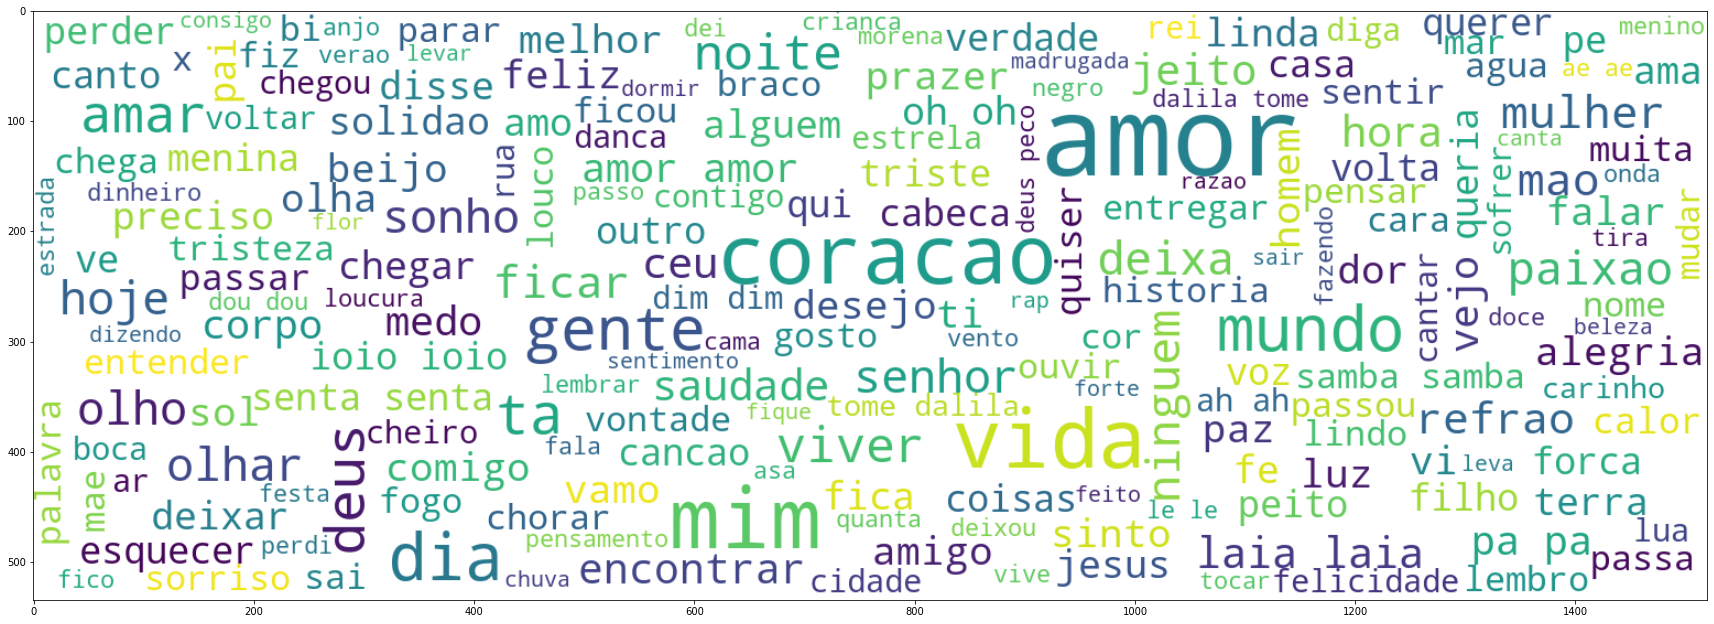

In [11]:
# Nuvem para todas as palavras
fig, ax = plt.subplots(1, 1, figsize=(30,30))
text = " ".join(review for review in df_br_[(df_br_['is_pt'] != 'Tradução ')]['Transformed'])
ax.imshow(WordCloud(max_font_size=100,width = 1520, height = 535, background_color="white").generate(text), interpolation="bilinear")

Diferentes estilos de musicas ocasionam em uma maior ou menor diversidade de palavras? 

Para responder esta pergunta, foi realizada a redução de palavras duplicadas em cada letra. Para melhor exemplificação:

- Supõe-se que tem uma música que contém 30 palavras, sendo que 5 são duplicadas e outra música que contém 100 palavras e apenas 10 duplicadas. Retirando as duplicidades, tem - se 20 palavras na primeira e 80 na segunda. Neste caso, a segunda música contém uma diversidade maior de palavras utilizadas.

- De acordo com os histogramas gerados, percebe-se que o Samba contém músicas com maior concentração de variedade do que as outras

In [12]:
%%time
df_br_['Reduce'] = df_br_['Transformed'].apply(lambda x: ' '.join(unique_list(x.split())))
df_br_['len'] = df_br_['Reduce'].apply(lambda x: len(x))

CPU times: user 46.9 ms, sys: 15.6 ms, total: 62.5 ms
Wall time: 42.8 ms
<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


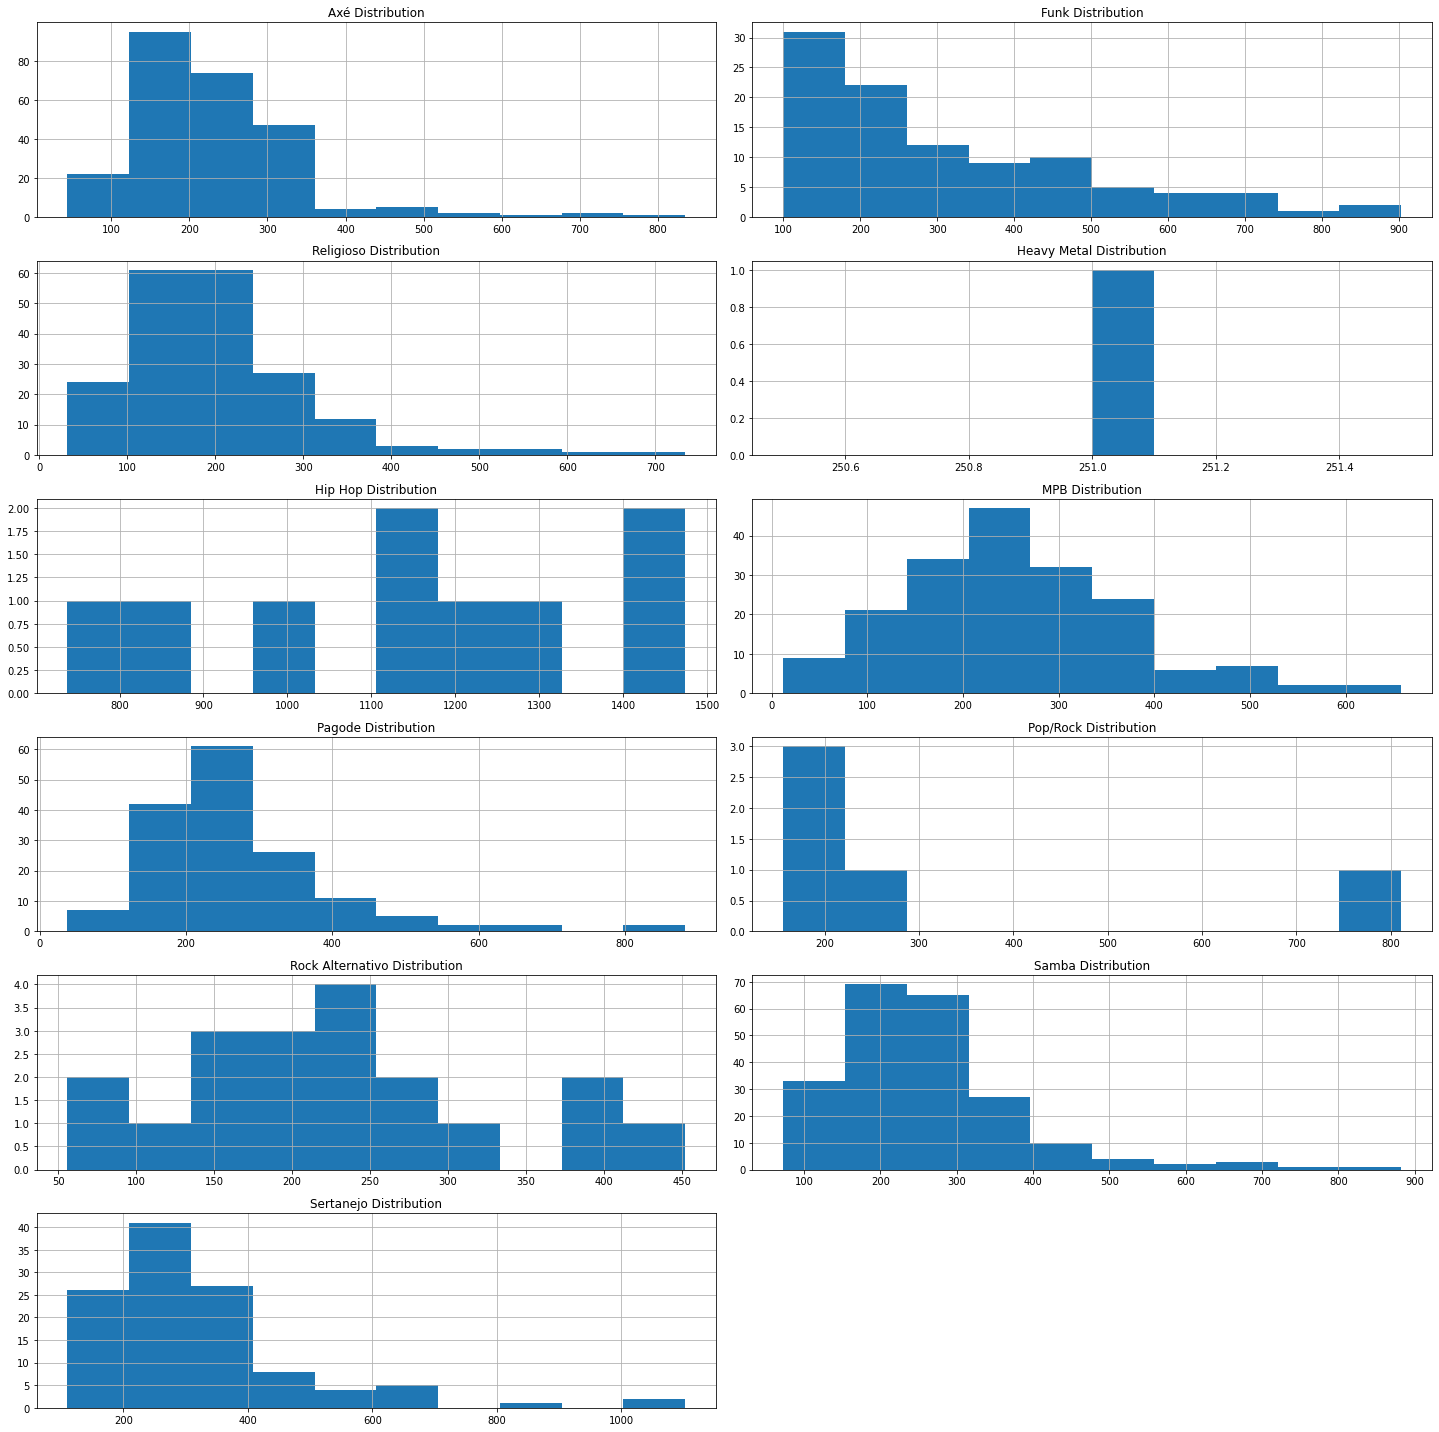

CPU times: user 2.81 s, sys: 578 ms, total: 3.39 s
Wall time: 3.21 s


In [13]:
%%time
categorys = df_br_[df_br_['is_pt'] != "Tradução "]['category'].unique()

def draw_histograms(df, categorys, n_rows, n_cols):
    fig=plt.figure(figsize=(20,20))

    for i, var_name in enumerate(categorys):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[df['category']== var_name]['len'].hist(bins = 10, ax=ax)
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df_br_, categorys, 6, 2)
    

# Aplicando modelos supervisionados

In [14]:
# Transformando rótulos em números
df_br_['fast_category'] = df_br_['category']
le = preprocessing.LabelEncoder()
le.fit(df_br_['category'].unique())
df_br_['category'] = le.transform(df_br_['category'])

<ipython-input-14-d7e7e4e82eea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_br_['fast_category'] = df_br_['category']
<ipython-input-14-d7e7e4e82eea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_br_['category'] = le.transform(df_br_['category'])


In [15]:
# Treino e teste
X_treino, X_valid, y_treino, y_valid = train_test_split(df_br_['Transformed'], df_br_['category'], test_size=0.3)

In [16]:
# Vectorizer
vect = TfidfVectorizer(max_features=60, min_df=2, ngram_range=(1,2))
X_treino_vect = vect.fit_transform(X_treino)
X_valid_vect = vect.fit_transform(X_valid)

### Random Forest

In [17]:
random = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, n_jobs = 6)
random.fit(X_treino_vect.todense(), y_treino)
predictions_random = random.predict(X_valid_vect.todense())

In [18]:
# Matriz de confusão
data = {'y_Actual':    y_valid,
        'y_Predicted': predictions_random}

df_pred = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_pred['y_Actual'], df_pred['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [19]:
# Validando modelo
print("F1: ", f1_score(y_valid, predictions_random, average='macro'))
print("ACC: ", accuracy_score(y_valid, predictions_random))
print("Precisão: ", precision_score(y_valid, predictions_random, average='macro'))

F1:  0.18256674184265065
ACC:  0.27393617021276595
Precisão:  0.20984912633519448
/home/joaoflauzino/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBOOST

In [20]:
clf = GradientBoostingClassifier(n_estimators= 1000, learning_rate=0.03, max_depth=1, random_state=0)
clf.fit(X_treino_vect.todense(), y_treino)
predictions_xgboost = clf.predict(X_valid_vect.todense())

In [21]:
# Validando modelo
print("F1: ", f1_score(y_valid, predictions_xgboost, average='macro'))
print("ACC: ", accuracy_score(y_valid, predictions_xgboost))
print("Precisão: ", precision_score(y_valid, predictions_xgboost, average='macro'))

F1:  0.17882150669170455
ACC:  0.2765957446808511
Precisão:  0.18893984937763816
/home/joaoflauzino/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### FastText

In [22]:
# Preparando label
df_br_['fast_category'] = df_br_['fast_category'].apply(lambda x: "__label__" + unidecode(x.lower()))

<ipython-input-22-b13d6945eda1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_br_['fast_category'] = df_br_['fast_category'].apply(lambda x: "__label__" + unidecode(x.lower()))


In [23]:

df_br_.shape[0]*0.7

876.4

In [24]:
df_br_.shape[0]*0.3

375.59999999999997

In [25]:
# Escrevendo base em arquivo txt
with open('../dataset/music.txt', 'w') as f:
    f.write(
        df_br_[['fast_category', 'Transformed']].to_string(header = False, index = False)
    )

In [26]:
# Separando entre treino e teste
os.system('head -n 852 ../dataset/music.txt > ../dataset/music_train.txt')
os.system('tail -n 364 ../dataset/music.txt > ../dataset/music_test.txt')

0

In [27]:
# Treinando modelo
model = fasttext.train_supervised(input="../dataset/music_train.txt", epoch=100, lr=0.335, wordNgrams=3, bucket=200000, dim=60, loss='hs')
model.save_model('model_music.bin')

In [28]:
# Testando
model.test('../dataset/music_test.txt')

(11, 0.09090909090909091, 0.09090909090909091)

# Aplicando regras não supervisionadas